### Stocks trader:

This notebook aims to maximize the total returns from trading a financial security (e.g. stocks, options, bonds, etc.).

**Input:** *input_data.csv* 

This file should include the daily trading data of the financial instrument over some extended historical period.  
This file should include four features: 'date', 'high', 'low', 'close'.  
'date' format must be ="%m/%d/%Y"


The input data used in this notebook are those of the **OMXS30 (OMX Stockholm 30 Index)**

**Outputs:**
. *trading_decisions.csv*
. *trained_model.pkl* 

#### How it works?

The algorithm decides (based on the historical data of the last few days) whether to buy the instrument at the opening price of the current day. The algorithm also sets a "Target price" and a "Stop-loss price".

To start with, two technical indicators of the historical prices are constructed:  
    . Simple Moving average  
    . Bollinger Bands (https://en.wikipedia.org/wiki/Bollinger_Bands)
    
Buy decisions are based on those two technical indicators (note that the design here only makes one buy transaction followed by one sell transaction; short selling and multiple buys are not considered). 

Moreover, Bollinger Bands are used to set the "Target price" and a "Stop-loss price". Specifically, the upper bound of the Band is set as the "Target price"; while the lower bound of the Band is set as the "Stop-loss price". 

Buy decisions are limited to *one day*. This means that if a buy decision is made on a gven day, then the transaction must be closed in the following day. This can occur in one of two ways: (1) the following day's price reached the "Taregt price", or (2) the following day's price reached the "Stop-loss price", or (3) if neither of the previous two events occured, then the transaction is automatically closed at the following day's closing price.


**To maximize returns:**  A machine learing approach is taken. Specifically, a model is trained to predict whether a buy decision in a given day would be profitable (given the above-noted constraints). The decision threshold of this model is then adjusted to maximize the returns.

In [ ]:
# reset variables
%reset -f

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_curve,  roc_auc_score

In [ ]:
# read input data (OMX Stockholm 30 Index)
df = pd.read_csv('input_data.csv')
df.head()

In [ ]:
# check input data are of the right structure
if len(set(["date", "high", "low", "close"]).intersection(set(df.columns))) != 4:
    print("Error! Input data are not of the right structure")
    print("Input file should include four features: 'date', 'high', 'low', 'close'")

In [5]:
# set the 'date' as the dataframe's index
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y")
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df

,high,low,close
date,,,
2007-09-03,"1,222.75","1,213.11","1,222.31"
2007-09-04,"1,226.60","1,210.38","1,226.08"
2007-09-05,"1,228.60","1,197.64","1,197.64"
2007-09-06,"1,207.81","1,184.91","1,190.67"
2007-09-07,"1,193.23","1,154.79","1,159.95"
...,...,...,...
2019-07-18,"1,600.22","1,573.55","1,577.41"
2019-07-19,"1,605.42","1,578.62","1,605.42"
2019-07-22,"1,607.45","1,598.11","1,600.88"


In [6]:
# change the formating of the 'high', 'low', and 'close' from string to float
df['high'] = df['high'].str.replace(',', '')
df['low'] = df['low'].str.replace(',', '')
df['close'] = df['close'].str.replace(',', '')
df = df.apply(pd.to_numeric)
df.head()

,high,low,close
date,,,
2007-09-03,1222.75,1213.11,1222.31
2007-09-04,1226.60,1210.38,1226.08
2007-09-05,1228.60,1197.64,1197.64
2007-09-06,1207.81,1184.91,1190.67
2007-09-07,1193.23,1154.79,1159.95


In [7]:
# create a lagged and lead versions of the prices
# the lagged prices will be used to make the buy decisions
# the lead versions will be used to know the profitability of these decisions
df['close_lag_1'] = df['close'].shift(1)
df['high_lead_1'] = df['high'].shift(-1)
df['low_lead_1'] = df['low'].shift(-1)
df['close_lead_1'] = df['close'].shift(-1)
df.head()

,high,low,close,close_lag_1,high_lead_1,low_lead_1,close_lead_1
date,,,,,,,
2007-09-03,1222.75,1213.11,1222.31,NaN,1226.60,1210.38,1226.08
2007-09-04,1226.60,1210.38,1226.08,1222.31,1228.60,1197.64,1197.64
2007-09-05,1228.60,1197.64,1197.64,1226.08,1207.81,1184.91,1190.67
2007-09-06,1207.81,1184.91,1190.67,1197.64,1193.23,1154.79,1159.95
2007-09-07,1193.23,1154.79,1159.95,1190.67,1168.96,1143.45,1147.20


In [8]:
# calculate Simple Moving Average with 5 and 3 days window
df['close_SMA_5'] = df['close'].rolling(window=5).mean()
df['close_SMA_3'] = df['close'].rolling(window=3).mean()

# calculate the standard deviation with 5 and 3 days window
std_5 = df['close'].rolling(window=5).std()
std_3 = df['close'].rolling(window=3).std()

# To measure volatility, calculate the upper and lower limits of the Bollinger Bands (with 5 and 3 days window)
df['close_Bollinger_upper_5'] = df['close_SMA_5'] + 2 * std_5
df['close_Bollinger_upper_3'] = df['close_SMA_3'] + 2 * std_3
df['close_Bollinger_lower_5'] = df['close_SMA_5'] - 2 * std_5
df['close_Bollinger_lower_3'] = df['close_SMA_3'] - 2 * std_3

df.apply(pd.to_numeric)

df.head()

,high,low,close,close_lag_1,high_lead_1,low_lead_1,close_lead_1,close_SMA_5,close_SMA_3,close_Bollinger_upper_5,close_Bollinger_upper_3,close_Bollinger_lower_5,close_Bollinger_lower_3
date,,,,,,,,,,,,,
2007-09-03,1222.75,1213.11,1222.31,NaN,1226.60,1210.38,1226.08,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-04,1226.60,1210.38,1226.08,1222.31,1228.60,1197.64,1197.64,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-05,1228.60,1197.64,1197.64,1226.08,1207.81,1184.91,1190.67,NaN,1215.343333,NaN,1246.237296,NaN,1184.449371
2007-09-06,1207.81,1184.91,1190.67,1197.64,1193.23,1154.79,1159.95,NaN,1204.796667,NaN,1242.313619,NaN,1167.279714
2007-09-07,1193.23,1154.79,1159.95,1190.67,1168.96,1143.45,1147.20,1199.33,1182.753333,1252.923647,1222.860152,1145.736353,1142.646514


In [9]:
df['profit'] = np.nan
df['is_profit'] = np.nan

# Calculate if a buy decision on a given day will be profitable
for index, row in df.iterrows():
    buy_price = row['close_lag_1'] # buy price is always the open price of the current day (i.e. the closing of the previous day)
    target_price = row['close_Bollinger_upper_5']
    stop_loss = row['close_Bollinger_lower_5']
    
    if math.isnan(buy_price) | math.isnan(target_price) | math.isnan(stop_loss):
        continue
    
    if buy_price > target_price or buy_price < stop_loss:
        continue  
    
    # Skip rows where the following day's prices have reached both the target and stop-loss prices
    # This is because it's impossible (based on daily prices) to determine whether transactions on this day would be profitable
    if (row['low_lead_1'] < stop_loss and row['high_lead_1'] > target_price):
        continue
        
    profit = row['close_lead_1'] - buy_price
    
    if row['low_lead_1'] < stop_loss:
        profit = stop_loss - buy_price
    elif row['high_lead_1'] > target_price:
            profit = target_price - buy_price
    
    df.at[index,'profit'] = profit
    if profit > 0 :
        df.at[index,'is_profit'] = 1
    elif profit <= 0: 
        df.at[index,'is_profit'] = 0

df.head(10)

,high,low,close,close_lag_1,high_lead_1,low_lead_1,close_lead_1,close_SMA_5,close_SMA_3,close_Bollinger_upper_5,close_Bollinger_upper_3,close_Bollinger_lower_5,close_Bollinger_lower_3,profit,is_profit
date,,,,,,,,,,,,,,,
2007-09-03,1222.75,1213.11,1222.31,NaN,1226.60,1210.38,1226.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-04,1226.60,1210.38,1226.08,1222.31,1228.60,1197.64,1197.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-05,1228.60,1197.64,1197.64,1226.08,1207.81,1184.91,1190.67,NaN,1215.343333,NaN,1246.237296,NaN,1184.449371,NaN,NaN
2007-09-06,1207.81,1184.91,1190.67,1197.64,1193.23,1154.79,1159.95,NaN,1204.796667,NaN,1242.313619,NaN,1167.279714,NaN,NaN
2007-09-07,1193.23,1154.79,1159.95,1190.67,1168.96,1143.45,1147.20,1199.330,1182.753333,1252.923647,1222.860152,1145.736353,1142.646514,-44.933647,0.0
2007-09-10,1168.96,1143.45,1147.20,1159.95,1173.97,1148.29,1172.42,1184.308,1165.940000,1247.025088,1210.630952,1121.590912,1121.249048,12.470000,1.0
2007-09-11,1173.97,1148.29,1172.42,1147.20,1180.60,1162.61,1180.60,1173.576,1159.856667,1215.456527,1185.077185,1131.695473,1134.636149,33.400000,1.0
2007-09-12,1180.60,1162.61,1180.60,1172.42,1198.78,1170.84,1196.63,1170.168,1166.740000,1204.317183,1201.558777,1136.018817,1131.921223,24.210000,1.0
2007-09-13,1198.78,1170.84,1196.63,1180.60,1196.14,1173.39,1179.76,1171.360,1183.216667,1209.293729,1207.847236,1133.426271,1158.586098,-0.840000,0.0


1.0    1556
0.0    1403
Name: is_profit, dtype: int64


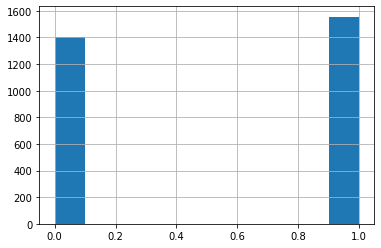

In [10]:
print(df['is_profit'].value_counts())
df['is_profit'].hist()

In [11]:
# To build the ML model, use SMA and the upper bound of the Bollinger Bands (including the lower bund would be redundant)
X = df.iloc[:, 7:11] 
X.head()

,close_SMA_5,close_SMA_3,close_Bollinger_upper_5,close_Bollinger_upper_3
date,,,,
2007-09-03,NaN,NaN,NaN,NaN
2007-09-04,NaN,NaN,NaN,NaN
2007-09-05,NaN,1215.343333,NaN,1246.237296
2007-09-06,NaN,1204.796667,NaN,1242.313619
2007-09-07,1199.33,1182.753333,1252.923647,1222.860152


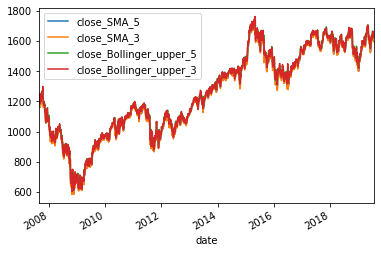

In [12]:
X.plot()

In [13]:
# To avoid predicting the trend rather than the underlying data-generating process
# Use a differenced version of the technical indicators
X = X.diff()
X = X.add_prefix('diff_')
X.head(10)

,diff_close_SMA_5,diff_close_SMA_3,diff_close_Bollinger_upper_5,diff_close_Bollinger_upper_3
date,,,,
2007-09-03,NaN,NaN,NaN,NaN
2007-09-04,NaN,NaN,NaN,NaN
2007-09-05,NaN,NaN,NaN,NaN
2007-09-06,NaN,-10.546667,NaN,-3.923677
2007-09-07,NaN,-22.043333,NaN,-19.453467
2007-09-10,-15.022,-16.813333,-5.898559,-12.229200
2007-09-11,-10.732,-6.083333,-31.568561,-25.553767
2007-09-12,-3.408,6.883333,-11.139344,16.481592
2007-09-13,1.192,16.476667,4.976546,6.288459


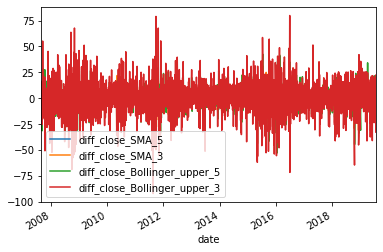

In [14]:
# Visually confirm the trend in the data is removed
X.plot()

In [15]:
# remove rows for which any of features or dependent variable is missing
X['is_profit'] = df['is_profit']
X.dropna(inplace=True)
X.head()

,diff_close_SMA_5,diff_close_SMA_3,diff_close_Bollinger_upper_5,diff_close_Bollinger_upper_3,is_profit
date,,,,,
2007-09-10,-15.022,-16.813333,-5.898559,-12.229200,1.0
2007-09-11,-10.732,-6.083333,-31.568561,-25.553767,1.0
2007-09-12,-3.408,6.883333,-11.139344,16.481592,1.0
2007-09-13,1.192,16.476667,4.976546,6.288459,0.0
2007-09-14,3.962,2.446667,2.095604,-3.170514,0.0


In [16]:
y = X['is_profit']
X = X.iloc[:, :4]
X.head()

,diff_close_SMA_5,diff_close_SMA_3,diff_close_Bollinger_upper_5,diff_close_Bollinger_upper_3
date,,,,
2007-09-10,-15.022,-16.813333,-5.898559,-12.229200
2007-09-11,-10.732,-6.083333,-31.568561,-25.553767
2007-09-12,-3.408,6.883333,-11.139344,16.481592
2007-09-13,1.192,16.476667,4.976546,6.288459
2007-09-14,3.962,2.446667,2.095604,-3.170514


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

In [18]:
# Train the model that predicts whether the transaction on a given day will be profitable (when sold the following day)
stratkfold = StratifiedKFold(n_splits = 5, shuffle = True)
clf = LogisticRegression(solver = "lbfgs")
scores = cross_val_score(clf, X_train, y_train, cv=stratkfold, n_jobs = -1, scoring='roc_auc')
print("The model's area under the ROC curve (based on cross-validated training data) is %.2f" % scores.mean())

The model's area under the ROC curve (based on cross-validated training data) is 0.69


In [19]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
y_predicted = clf.predict(X_test)
print("The model's area under the ROC curve (based on test data) is %.2f" % roc_auc_score(y_test, y_predicted))

The model's area under the ROC curve (based on test data) is 0.64


The decision thresold where the predictor's performance is optimized is 0.5457 


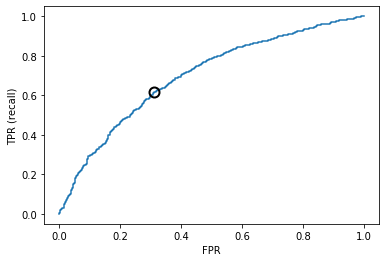

In [21]:
# Optimize the decision threshold of the trained model
# based on Youden's J statistic (https://en.wikipedia.org/wiki/Youden%27s_J_statistic)

pred_prob = clf.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, pred_prob)

# calculate j-scores for all decision thresholds
j_scores = tpr-fpr

# Find the max j-score and its threshold
j_ordered = sorted(zip(j_scores,thresholds))
max_j_train = j_ordered[-1][0]
threshold_of_max = j_ordered[-1][1]

print("The decision thresold where the predictor's performance is optimized is %.4f " % threshold_of_max)

close_max_threshold = np.argmin(np.abs(thresholds - threshold_of_max))

plt.plot(fpr, tpr)
plt.plot(fpr[close_max_threshold], tpr[close_max_threshold], 'o', markersize=10,
             label=("Youden's J max"), fillstyle="none", c='k', mew=2)
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C9CE7C8>]],
      dtype=object)

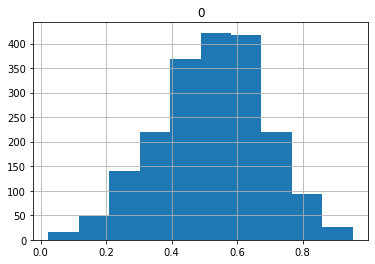

In [22]:
pd.DataFrame(pred_prob).hist()

In [23]:
# Now fit on all the data
clf.fit(X, y)
pred_prob = clf.predict_proba(X)[:, 1]
X['pred_prob'] = pred_prob

In [24]:
X['buy'] =  [1 if x > threshold_of_max else 0 for x in X['pred_prob']]
X.head()

,diff_close_SMA_5,diff_close_SMA_3,diff_close_Bollinger_upper_5,diff_close_Bollinger_upper_3,pred_prob,buy
date,,,,,,
2007-09-10,-15.022,-16.813333,-5.898559,-12.229200,0.214441,0
2007-09-11,-10.732,-6.083333,-31.568561,-25.553767,0.394631,0
2007-09-12,-3.408,6.883333,-11.139344,16.481592,0.658094,1
2007-09-13,1.192,16.476667,4.976546,6.288459,0.846301,1
2007-09-14,3.962,2.446667,2.095604,-3.170514,0.578108,1


In [25]:
# Concatenate with the main dataframe
result =  pd.concat([df, X], axis=1, sort=False)
result.tail()

,high,low,close,close_lag_1,high_lead_1,low_lead_1,close_lead_1,close_SMA_5,close_SMA_3,close_Bollinger_upper_5,...,close_Bollinger_lower_5,close_Bollinger_lower_3,profit,is_profit,diff_close_SMA_5,diff_close_SMA_3,diff_close_Bollinger_upper_5,diff_close_Bollinger_upper_3,pred_prob,buy
date,,,,,,,,,,,,,,,,,,,,,
2019-07-18,1600.22,1573.55,1577.41,1598.06,1605.42,1578.62,1605.42,1612.914,1602.013333,1661.434018,...,1564.393982,1548.414153,7.36,1.0,-7.160,-18.500000,12.421847,-3.861468,0.183463,0.0
2019-07-19,1605.42,1578.62,1605.42,1577.41,1607.45,1598.11,1600.88,1608.874,1593.630000,1655.428288,...,1562.319712,1564.588051,23.47,1.0,-4.040,-8.383333,-6.005730,-32.940565,0.372210,0.0
2019-07-22,1607.45,1598.11,1600.88,1605.42,1627.87,1602.22,1624.77,1602.468,1594.570000,1640.524435,...,1564.411565,1564.503268,19.35,1.0,-6.406,0.940000,-14.903852,1.964783,0.542089,0.0
2019-07-23,1627.87,1602.22,1624.77,1600.88,1625.54,1608.29,1613.06,1601.308,1610.356667,1635.208163,...,1567.407837,1584.982583,12.18,1.0,-1.160,15.786667,-5.316272,11.094018,0.827746,1.0
2019-07-24,1625.54,1608.29,1613.06,1624.77,NaN,NaN,NaN,1604.308,1612.903333,1639.404739,...,1569.211261,1589.011792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Calculate the actual Profit & Loss based on the buy decisions
result['actual P&L'] =  result['buy'] *  result['profit'] 
result['actual P&L'] = [0 if x == 0 else x for x in result['actual P&L']]
result.tail(10)

,high,low,close,close_lag_1,high_lead_1,low_lead_1,close_lead_1,close_SMA_5,close_SMA_3,close_Bollinger_upper_5,...,close_Bollinger_lower_3,profit,is_profit,diff_close_SMA_5,diff_close_SMA_3,diff_close_Bollinger_upper_5,diff_close_Bollinger_upper_3,pred_prob,buy,actual P&L
date,,,,,,,,,,,,,,,,,,,,,
2019-07-11,1631.35,1609.44,1613.21,1622.45,1629.20,1613.31,1625.62,1628.710,1622.180000,1651.103057,...,1604.503813,3.170000,1.0,-7.808,-9.620000,-8.009329,-11.628416,0.327273,0.0,0.000000
2019-07-12,1629.20,1613.31,1625.62,1613.21,1639.00,1615.59,1632.91,1626.846,1620.426667,1648.172315,...,1607.531329,19.700000,1.0,-1.864,-1.753333,-2.930742,-6.534183,0.492994,0.0,0.000000
2019-07-15,1639.00,1615.59,1632.91,1625.62,1633.72,1620.44,1630.57,1625.014,1623.913333,1640.603500,...,1603.992788,4.950000,1.0,-1.832,3.486667,-7.568815,10.511875,0.588282,1.0,4.950000
2019-07-16,1633.72,1620.44,1630.57,1632.91,1630.91,1598.06,1598.06,1624.952,1629.700000,1640.426898,...,1622.255888,-23.432898,0.0,-0.062,5.786667,-0.176602,-6.689767,0.669831,1.0,-23.432898
2019-07-17,1630.91,1598.06,1598.06,1630.57,1600.22,1573.55,1577.41,1620.074,1620.513333,1649.012171,...,1581.552685,-39.434171,0.0,-4.878,-9.186667,8.585272,22.329870,0.312826,0.0,0.000000
2019-07-18,1600.22,1573.55,1577.41,1598.06,1605.42,1578.62,1605.42,1612.914,1602.013333,1661.434018,...,1548.414153,7.360000,1.0,-7.160,-18.500000,12.421847,-3.861468,0.183463,0.0,0.000000
2019-07-19,1605.42,1578.62,1605.42,1577.41,1607.45,1598.11,1600.88,1608.874,1593.630000,1655.428288,...,1564.588051,23.470000,1.0,-4.040,-8.383333,-6.005730,-32.940565,0.372210,0.0,0.000000
2019-07-22,1607.45,1598.11,1600.88,1605.42,1627.87,1602.22,1624.77,1602.468,1594.570000,1640.524435,...,1564.503268,19.350000,1.0,-6.406,0.940000,-14.903852,1.964783,0.542089,0.0,0.000000
2019-07-23,1627.87,1602.22,1624.77,1600.88,1625.54,1608.29,1613.06,1601.308,1610.356667,1635.208163,...,1584.982583,12.180000,1.0,-1.160,15.786667,-5.316272,11.094018,0.827746,1.0,12.180000


In [27]:
print ("The distribution of buy decisions is:\n" , result['buy'].value_counts(), sep= "")

The distribution of buy decisions is:
0.0    1589
1.0    1369
Name: buy, dtype: int64


In [28]:
print("The total P&L based on the trained model would be %.2f Swedish Kronor" % result['actual P&L'].sum())

The total P&L based on the trained model would be 8904.99 Swedish Kronor


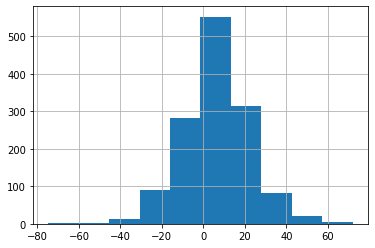

In [29]:
result['actual P&L'].iloc[result['actual P&L'].to_numpy().nonzero()].hist()

In [30]:
# Total P&L from Jan 1 to Aug 1 2019
result['actual P&L'].loc['2019-01-01' : '2019-08-01'].sum()

694.9419087313324

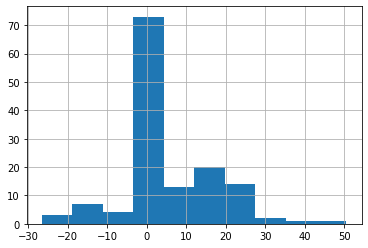

In [31]:
result['actual P&L'].loc['2019-01-01' : '2019-08-01'].hist()

In [32]:
# Save the trained ML model
joblib.dump(clf, "trained_model.pkl") 

['trained_model.pkl']

In [34]:
# save results of best to file
trading_decisions = result[['high', 'low', 'close', 'buy', 'actual P&L']]
trading_decisions.to_csv('trading_decisions.csv', index = True)